In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,decomposition
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3060 Ti
__CUDA Device Total Memory [GB]: 8.589279232
Running on the GPU


In [291]:
data = pd.read_csv('X_data_20_0_0.csv')
data = data.drop(['0','1'],axis=1)
X = data
pca = decomposition.PCA(n_components=10, svd_solver='full')
X = pd.DataFrame(pca.fit_transform(X))
labels = pd.read_csv('y_data_20_0_0.csv')
y = (labels['team1_pts']>labels['team2_pts']).astype(int)
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.4,shuffle=False)
#X_valid, X_test, y_valid, y_test = train_test_split( X_valid, y_valid, test_size=0.5,shuffle=False)
WIDTH = len(X.columns.values)

In [292]:
from numpy import dtype
import math
from matplotlib import pyplot as plt
from sklearn import metrics

x_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

x_train_torch = torch.from_numpy(x_train_np).float()
y_train_torch = torch.from_numpy(y_train_np).float()
x_train_torch = x_train_torch.to(device)
y_train_torch = y_train_torch.to(device)

x_valid_np = X_valid.to_numpy()
y_valid_np = y_valid.to_numpy()

x_valid_torch = torch.from_numpy(x_valid_np).float()
y_valid_torch = torch.from_numpy(y_valid_np).float()

x_valid_torch = x_valid_torch.to(device)
y_valid_torch = y_valid_torch.to(device)

def out_of_sample_error():

    predicted = []
    actual = []

    with torch.no_grad():
        for idx,data in enumerate(x_valid_torch):
            output = model(data.view(-1,WIDTH))

            predicted += [output.item()]
            actual += [y_valid_torch[idx].item()]
            
    return metrics.mean_absolute_error(actual, predicted)

def in_sample_error():

    predicted = []
    actual = []

    with torch.no_grad():
        for idx,data in enumerate(x_train_torch):
            output = model(data.view(-1,WIDTH))

            predicted += [output.item()]
            actual += [y_train_torch[idx].item()]

    return metrics.mean_absolute_error(actual, predicted)

def plot_out_of_sample_error():
    predicted = []
    actual = []

    with torch.no_grad():
        for idx,data in enumerate(x_valid_torch):
            output = model(data.view(-1,WIDTH))

            predicted += [output.item()]
            actual += [y_valid_torch[idx].item()]
    plt.scatter(predicted,actual)

def plot_in_sample_error():
    predicted = []
    actual = []

    with torch.no_grad():
        for idx,data in enumerate(x_train_torch):
            output = model(data.view(-1,WIDTH))

            predicted += [output.item()]
            actual += [y_train_torch[idx].item()]
    plt.scatter(predicted,actual)

In [316]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. The Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# The Flatten layer flatens the output of the linear layer to a 1D tensor,
# to match the shape of `y`.
from torch import sigmoid


model = torch.nn.Sequential(
    torch.nn.Linear(WIDTH, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 1),
    torch.nn.Sigmoid(),
    torch.nn.Flatten(0, 1)
)
model.to(device)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
numPasses = 1500
for t in range(numPasses):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x_train_torch)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y_train_torch)
    if t % 100 == 99:
        print(t, loss.item(), round(in_sample_error(),3), round(out_of_sample_error(),3))
        pass

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

99 423.6380920410156 0.45 0.462
199 415.4737548828125 0.442 0.454
299 410.5541687011719 0.438 0.451
399 407.3132629394531 0.434 0.448
499 404.87677001953125 0.432 0.447
599 402.52191162109375 0.43 0.446
699 400.6705017089844 0.427 0.446
799 399.0223388671875 0.425 0.445
899 397.6649169921875 0.424 0.445
999 396.4837951660156 0.422 0.445
1099 395.5166015625 0.421 0.444
1199 394.800048828125 0.42 0.444
1299 393.7889404296875 0.419 0.444
1399 393.27069091796875 0.418 0.444
1499 392.68603515625 0.417 0.443


(array([ 21., 127., 240., 227., 355., 278., 232., 202., 142.,  50.]),
 array([0.02979875, 0.12576354, 0.22172832, 0.3176931 , 0.4136579 ,
        0.5096227 , 0.6055875 , 0.7015523 , 0.79751706, 0.89348185,
        0.98944664], dtype=float32),
 <BarContainer object of 10 artists>)

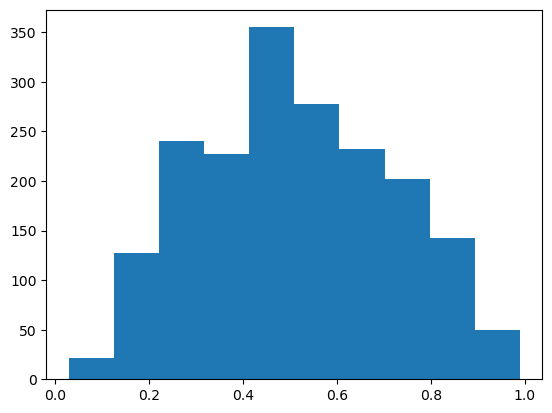

In [317]:
plt.hist(y_pred.cpu().detach().numpy())

In [318]:
correct = 0
total = 0

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_train_torch)):
        output = model(data.view(-1,WIDTH))

        if round(output.item()) == y_train_torch[idx].item():
            correct = correct + 1
        total = total + 1

print("Train Accuracy: ", round(correct/total, 3))

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_valid_torch)):
        output = model(data.view(-1,WIDTH))

        if round(output.item()) == y_valid_torch[idx].item():
            correct = correct + 1
        total = total + 1

print("Valid Accuracy: ", round(correct/total, 3))

1874it [00:00, 1896.82it/s]


Train Accuracy:  0.693


1250it [00:00, 2250.07it/s]

Valid Accuracy:  0.668


In [327]:
conf_thresh = .00

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_train_torch)):
        output = model(data.view(-1,WIDTH))
        if abs(output.item()-.5) > conf_thresh:
            if round(output.item()) == y_train_torch[idx].item():
                correct = correct + 1
            total = total + 1

print("Train Accuracy: ", round(correct/total, 3))

with torch.no_grad():
    for idx,data in tqdm(enumerate(x_valid_torch)):
        output = model(data.view(-1,WIDTH))
        if abs(output.item()-.5) > conf_thresh:
            if round(output.item()) == y_valid_torch[idx].item():
                correct = correct + 1
            total = total + 1

print("Valid Accuracy: ", round(correct/total, 3))

1874it [00:00, 1932.71it/s]


Train Accuracy:  0.687


1250it [00:00, 2051.58it/s]

Valid Accuracy:  0.683
